In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
exec(open("startup.py").read())

date : Wed Aug 28 09:10:59 PDT 2019
hostname : bragi
whoami : tmb
pwd : /home/tmb/exp/icdar2019dl



In [3]:
from webdataset import WebDataset

# Class Encoding

In [4]:
def encode_str(s): return [ord(c)-ord("0")+1 for c in s]
def decode_str(l): return "".join([chr(k+ord("0")-1) for k in l])

encode_str("019")

[1, 2, 10]

# Datasets

In [5]:
!tar -tvf data/digits-training.tar | sed 5q

-r--r--r-- bigdata/bigdata 4941 2019-08-28 03:10 0.ppm
-r--r--r-- bigdata/bigdata    3 2019-08-28 03:10 0.txt
-r--r--r-- bigdata/bigdata 6286 2019-08-28 03:10 1.ppm
-r--r--r-- bigdata/bigdata    4 2019-08-28 03:10 1.txt
-r--r--r-- bigdata/bigdata 7630 2019-08-28 03:10 2.ppm
tar: write error


In [6]:
transforms = [
    lambda x: (torch.tensor(x)[:48,:].float()/255.0).unsqueeze(2),
    lambda s: torch.tensor(encode_str(s)).long()
]

training = WebDataset("data/digits-training.tar", extensions="ppm txt",
                           decoder="l", transforms=transforms)
testing = WebDataset("data/digits-testing.tar", extensions="ppm txt",
                          decoder="l", transforms=transforms)


# Collation and Data Loaders

torch.Size([5, 48, 136, 1]) torch.Size([20]) torch.Size([5]) torch.Size([5])
tensor(0.) tensor(0.0039) tensor(1) tensor(10)


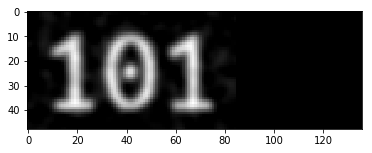

In [7]:
def collate4ocr(samples):
    images, seqs = zip(*samples)
    w, h, d = map(max, zip(*[x.shape for x in images]))
    result = torch.zeros((len(images), w, h, d))
    for i, im in enumerate(images):
        w, h, d = im.shape
        result[i, :w, :h, :d] = im
    allwidths = torch.tensor([im.shape[1] for im in images]).long()
    allseqs = torch.cat(seqs).long()
    alllens = torch.tensor([len(s) for s in seqs]).long()
    return (result, allseqs, allwidths, alllens)

training_dl = DataLoader(training, batch_size=5, collate_fn=collate4ocr)

for images, seqs, images_lens, seqs_lens in training_dl:
    print(images.shape, seqs.shape, images_lens.shape, seqs_lens.shape)
    print(images.min(), images.max(), seqs.min(), seqs.max())
    break
    
imshow(images[0,:,:,0])

# Model and Size Inference

In [8]:
ninput = 48
noutput = 11

def make_model():
    return nn.Sequential(
        layers.Input("BHWD", "BDHW", range=(0, 1), sizes=[None, 1, 48, None]),
        flex.Conv2d(100, 3, padding=(1, 1)),  # BDWH
        nn.ReLU(),
        layers.Reshape(0, [1, 2], 3), # BDL
        flex.Lstm1(100, bidirectional=True), # BDL
        flex.Conv1d(noutput, 1),
        layers.Reorder("BDL", "BLD"))

model = make_model()
flex.shape_inference(model, images.shape)
model

Sequential(
  (0): Input(BHWD->BDHW torch.float32 (0, 1) cpu [None, 1, 48, None])
  (1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Reshape(0, [1, 2], 3)
  (4): BDL_LSTM(
    (lstm): LSTM(4800, 100, bidirectional=True)
  )
  (5): Conv1d(200, 11, kernel_size=(1,), stride=(1,))
  (6): Reorder("BDL", "BLD")
)

# Training

In [9]:
model.to("cuda:1")
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
ctc_loss = nn.CTCLoss()

In [10]:
images, targets, ilens, tlens = next(iter(training_dl))

In [11]:
optimizer.zero_grad()

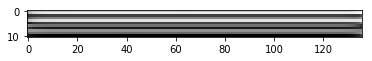

In [12]:
outputs = model.forward(images)
imshow(outputs[0].detach().cpu().numpy().T)

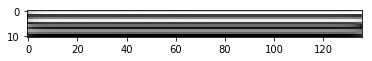

In [13]:
outputs = outputs.permute(1, 0, 2).cpu() # BLD -> LBD
l, b, d = outputs.shape
probs = outputs.log_softmax(2)
imshow(exp(probs[:,0,:].detach().cpu().numpy().T))

In [14]:
plens = torch.full((b,), l).long()
loss = ctc_loss(probs, targets, plens, tlens)
print(loss)

tensor(73.7731, grad_fn=<MeanBackward0>)


In [15]:
loss.backward()
nn.utils.clip_grad_norm_(model.parameters(), 10.0)
optimizer.step()

# Full Training Loops

In [16]:
losses = []
for epoch in range(3):
    i = 0
    for images, targets, ilens, tlens in training_dl:
        optimizer.zero_grad()
        outputs = model.forward(images.cuda())
        b, l, d = outputs.shape
        probs = outputs.permute(1, 0, 2).cpu().log_softmax(2) # LBD
        plens = torch.full((b,), l).long()
        loss = ctc_loss(probs, targets, plens, tlens)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
        if len(losses)%10==0: 
            print("epoch {:2d}   #samples {:8d}   loss {:8.3f}".format(
                epoch, len(losses)*images.size(0), mean(losses[-100:])),
                  end="\r", flush=True, file=sys.stderr)

KeyboardInterrupt: 

In [ ]:
import scipy.ndimage as ndi
figsize(6, 6)
xscale('log'); yscale('log')
plot(ndi.gaussian_filter(losses, 20.0)[::20])

# Trained Model

In [ ]:
figsize(10, 10)
for i in range(5):
    subplot(5, 2, 2*i+1); imshow(images[i,:,:,0].detach().numpy())
    subplot(5, 2, 2*i+2); imshow(outputs.softmax(2)[i].detach().cpu().numpy().T)

# Output Decoding

In [ ]:
probs = outputs[0].softmax(1).detach().cpu().numpy()
assert (abs(probs.sum(1)-1) < 1e-4).all()
imshow(probs.T)

In [ ]:
probs = ndi.gaussian_filter(probs, (1.0, 0))
probs /= probs.sum(1)[:,newaxis]
imshow(probs.T)

In [ ]:
labels, n = ndi.label(probs[:,0]<0.7)
mask = tile(labels[:,newaxis], (1, probs.shape[1]))
imshow(mask.T)

In [ ]:
ndi.maximum_position(probs, mask, arange(1, amax(mask)+1))

In [ ]:
import helpers; reload(helpers)
helpers.ctc_decode(outputs[0].softmax(1), full=True)

In [ ]:
decode_str(helpers.ctc_decode(outputs[0].softmax(1)))

# End-to-End Recognition

In [ ]:
figsize(10, 10)
outputs = model(images.cuda())
for i in range(5):
    subplot(3, 2,i+1)
    gca().set_title(decode_str(helpers.ctc_decode(outputs[i].softmax(1))))
    xticks([]); yticks([])
    imshow(images[i,:,:,0].detach().numpy())

# Trainers and Error Measurements

In [ ]:
from helpers import method

In [ ]:
class Trainer(object):
    def __init__(self, model, shape, lr): pass
    def train_batch(self, inputs, targets, ilens, tlens): pass
    def train(self, loader, epochs): pass
    def probs_batch(self, inputs, ilens): pass
    def predict_batch(self, inputs, ilens): pass
    def errors(self, loader): pass

In [ ]:
class Trainer(object):
    pass

In [ ]:
@method(Trainer)
def __init__(self, model, lr=1e-4):
    self.model = model
    self.model.cuda()
    self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    self.ctc_loss = nn.CTCLoss()

In [ ]:
@method(Trainer)
def train_batch(self, inputs, targets, ilens, tlens):
    self.optimizer.zero_grad()
    b_inputs, h, w, channels = inputs.shape
    outputs = self.model.forward(inputs.cuda())
    b, l, nclasses = outputs.shape
    assert b_inputs == b
    logprobs = outputs.permute(1, 0, 2).cpu().log_softmax(2)
    lplens = torch.full((b,), l).long()
    loss = self.ctc_loss(logprobs, targets, lplens, tlens)
    nn.utils.clip_grad_norm_(self.model.parameters(), 10.0)
    loss.backward()
    self.optimizer.step()
    return loss.detach().item()

In [ ]:
@method(Trainer)
def train(self, loader, epochs=1, total=None):
    for epoch in range(epochs):
        count = 0
        losses = []
        for images, targets, ilens, tlens in loader:
            if count%10==0:
                avgloss = mean(losses[-100:]) if len(losses)>0 else 0.0
                print(f"{epoch:3d} {count:9d} {avgloss:10.4f}", " "*10, file=sys.stderr, end="\r", flush=True)
            loss = self.train_batch(images, targets, ilens, tlens)
            losses.append(loss)
            count += 1
        print("", file=sys.stderr)

In [ ]:
@method(Trainer)
def probs_batch(self, inputs, ilens=None):
    with torch.no_grad():
        outputs = outputs = model.forward(inputs.cuda())
    return outputs.detach().cpu().softmax(2)

In [ ]:
@method(Trainer)
def predict_batch(self, inputs, ilens=None):
    probs = self.probs_batch(inputs)
    result = [ctc_decode(p) for p in probs]
    return result

In [ ]:
import editdistance

@method(Trainer)
def errors(self, loader):
    total = 0
    errors = 0
    for inputs, targets, ilens, tlens in loader:
        predictions = self.predict_batch(inputs)
        start = 0
        for p, l in zip(predictions, tlens):
            t = targets[start:start+l].tolist()
            errors += editdistance.distance(p, t)
            total += len(t)
            start += l
    return errors, total

In [ ]:
model = make_model()
flex.shape_inference(model, images.shape)
trainer = Trainer(model)
trainer.train(training_dl, 3, 50000)

In [ ]:
trainer.predict_batch(images, ilens)

In [ ]:
[decode_str(l) for l in trainer.predict_batch(images, ilens)]

In [ ]:
testing_dl = DataLoader(testing, batch_size=40, collate_fn=collate4ocr)
trainer.errors(testing_dl)

# Saving

In [ ]:
torch.save(model.state_dict(), "models/lstm-ctc-digits.state.pth")